In [1]:
!pip install sentencepiece



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install transformers torch



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip show sentencepiece

Name: sentencepiece
Version: 0.2.0
Summary: SentencePiece python wrapper
Home-page: https://github.com/google/sentencepiece
Author: Taku Kudo
Author-email: taku@google.com
License: Apache
Location: /media/guru/Storage/Sem5/DL/DL-Project/.venv/lib/python3.10/site-packages
Requires: 
Required-by: 


In [3]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
from PIL import Image
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/media/guru/Storage/Sem5/DL/DL-Project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, XLMRobertaTokenizerFast

# Load the tokenizer directly
tokenizer = XLMRobertaTokenizerFast.from_pretrained("naver-clova-ix/donut-base")

# Load the processor and model
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base", tokenizer=tokenizer)
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Ensure the model is in evaluation mode
model.eval()


2024-08-04 18:11:56.382555: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-04 18:11:56.416058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 18:11:56.460131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 18:11:56.460215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 18:11:56.490892: I tensorflow/core/platform/cpu_feature_gua

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [7]:

image_url = "../../../sample-data/bankforms.jpeg"
image = Image.open(image_url)

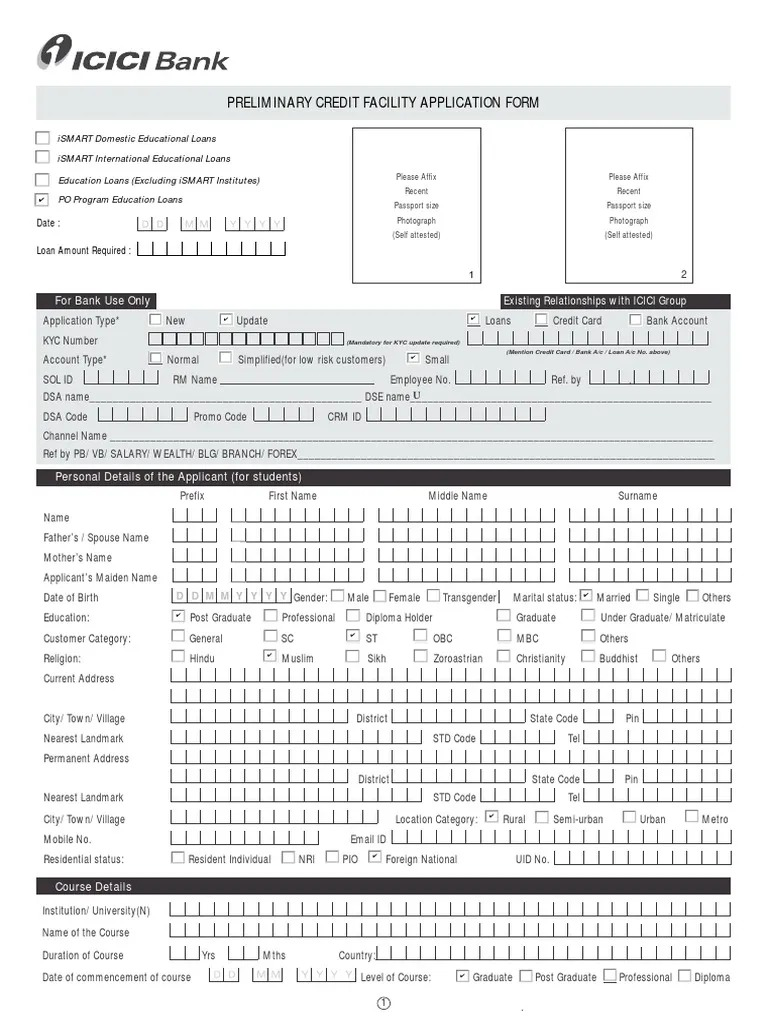

In [12]:
image

In [14]:
pixel_values

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

In [11]:
# Preprocess the image and perform OCR
pixel_values = processor(images=image, return_tensors="pt").pixel_values

outputs = model.generate(pixel_values, max_length=512, num_beams=4, early_stopping=True)

# Decode the output to get the OCR result
text = processor.batch_decode(outputs, skip_special_tokens=True)

# Print recognized text
print("Recognized Text:", text)


Recognized Text: ['']


In [9]:
def extract_boxes_from_output(outputs):
    boxes = []

    # Example: Assuming the output is in JSON format with a key 'bbox' that contains the coordinates
    for output in outputs:
        # Decode the output to get JSON string
        decoded_output = processor.decode(output, skip_special_tokens=True)
        
        # Convert JSON string to dictionary
        output_dict = json.loads(decoded_output)
        
        # Extract bounding box information
        if 'bbox' in output_dict:
            for bbox in output_dict['bbox']:
                x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
                boxes.append((x, y, w, h))

    return boxes

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Sample function to draw bounding boxes
def draw_boxes(image, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box in boxes:
        # Extract box coordinates
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Assuming `boxes` contains the bounding box coordinates
# boxes = [(x, y, width, height), ...]
boxes = extract_boxes_from_output(outputs)  # You need to implement this function based on Donut's output format

draw_boxes(image, boxes)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)